In [1]:
#Imports

############### Custom Modules (my modules) #################
from load_gas_asset_data import load_data                             
from transform_gas_asset_data import common_transform
from transform_gas_asset_data import ed_transform
from transform_gas_asset_data import ef_transform
from load_gas_asset_data import projects
from create_target_features_gas_asset import binary_classification_data_prep_ef
from create_target_features_gas_asset import binary_classification_data_prep_ed

##### External Modules #######
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                 # Classic plot python module
import seaborn as sns                                           # Built on top of Matplotlib - much better aesthetics and faster to use
from sklearn.model_selection import train_test_split            # Split data into train (features and target) and test (features and target)         
from sklearn.model_selection import cross_val_score             # Model cross validation to avoid overfitting
from sklearn.model_selection import cross_validate              # Model cross validation to avoid overfitting (allows multiple metrics to be printed)
from imblearn.ensemble import BalancedRandomForestClassifier    # imblearn package  - Balance sample in every bagging
from sklearn.ensemble import RandomForestClassifier             # Sklearn based random forest
from sklearn.dummy import DummyClassifier                       # Dummy classifier to benchmark 
from sklearn import metrics                                     # Helps assess model quality
from sklearn.tree import DecisionTreeClassifier                 # Decisino tree classifier
from imblearn.ensemble import BalancedBaggingClassifier         # Balanced bagging
from sklearn.metrics import balanced_accuracy_score             # Balanced accuracy score
from imblearn.ensemble import EasyEnsembleClassifier            # Adaboost model ??
from imblearn.ensemble import RUSBoostClassifier                # Balanced Adaboost model
from sklearn.metrics import recall_score                        # Recall object
from sklearn.metrics import confusion_matrix                    # Confusion matrix object
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [2]:
#Set project key

# ed    =   Excation Damage
# ef    =   equipment failure
# mf    =   material failure
# cor   =   corrosion
# io    =   incorrect operation
# nf    =   natural forces
# of    =   outside force
# oth   =   other causes for leaks (no reported?)

project_key = 'cor'

#Load features and target from each project
#Target variable can change, by default is total leaks
df_features, df_target = load_data(project_key = project_key)

#Split into training and test sets
train_features, test_features, train_target, test_target = train_test_split(df_features, 
                                                                            df_target,
                                                                            test_size = 0.25,
                                                                            random_state = 42)

In [3]:
#####################################################################################################
###################################### MODELS USED ##################################################
#####################################################################################################
# THE FOLLOWING 4 MODELS ATTEMPT TO CAPTURE SIGNALS FROM THE DATASET:
# 4 Models were attempted for the imbalanced data:
## 0. DUMMY CLASSIFIER (fake, benchmark, baseline):
## 1. XGBOOST
## 3. BALANCED RANDOM FOREST
## 4. BALANCED BAGGING CLASSIFIER
## 4. EASY ENSEMBLE CLASSIFIER
## 4. RANDOM UNDER SAMPLE BOOST CLASSIFIER

In [4]:
#####################################################################################################
###################################### START: DUMMY CLASSIFIER ######################################
#####################################################################################################
dummy = DummyClassifier(strategy = "uniform", random_state = 69)
dummy.fit(train_features, train_target)
dummy_pred_target = dummy.predict(test_features)
print("\nDummy accuracy: ", dummy.score(test_features, test_target),"\n")
print(metrics.classification_report(dummy_pred_target, test_target))
#####################################################################################################
####################################### END: DUMMY CLASSIFIER #######################################
#####################################################################################################


Dummy accuracy:  0.497869439236 

              precision    recall  f1-score   support

           0       0.50      0.99      0.66     11675
           1       0.53      0.01      0.01     11793

   micro avg       0.50      0.50      0.50     23468
   macro avg       0.51      0.50      0.34     23468
weighted avg       0.51      0.50      0.34     23468



In [5]:
#####################################################################################################
######################## START: EXTREME GRADIENT BOSTING (XGBOOST) ##################################
#####################################################################################################

# This is an unbalanced problem , hence I need to use an argument for the xgboost in order to 
# balance the class, the argument used is called scale_pos_weight (scale positive class weight)
# and is simple the sum of negative classes divided by the sum of the positove classes. 
# Note: Another paramter that takes care of class unbalance when the unbalance is too extreme is
# max_delta_weight

# For this dataset:
neg = len(df_target[df_target == 0])
pos = len(df_target[df_target == 1])
scale_pos_weight = neg/pos

xgb  = XGBClassifier(scale_pos_weight = scale_pos_weight, 
                     max_delta_step = 10)
xgb.fit(train_features, train_target)
print("XGBoost Accuracy: ", xgb.score(test_features, test_target),"\n")
xgb_pred_target = xgb.predict(test_features)
print(metrics.classification_report(xgb_pred_target, test_target))

scoring = [ 'accuracy',
            'balanced_accuracy',
            'average_precision',
            'brier_score_loss',
            'f1',
            'f1_micro',
            'f1_macro',
            'f1_weighted',
            #'f1_samples', # only for multiclass
            'neg_log_loss',
            'precision', 
            'recall', 
            'roc_auc']

xgb_all_scores = cross_validate(xgb, 
                                df_features, 
                                df_target, 
                                scoring = scoring,
                                cv = 5, 
                                return_train_score = True)

xgb_all_scores_df = pd.DataFrame(xgb_all_scores)


#kfold = StratifiedKFold(n_splits=10, random_state=7)
kfold = KFold(n_splits = 10, random_state = 7)
results = cross_val_score(xgb, df_features, df_target, cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


# Scoring	                Function	                        Comment
# Classification		
# ‘accuracy’	                metrics.accuracy_score	
# ‘balanced_accuracy’	        metrics.balanced_accuracy_score	        for binary targets
# ‘average_precision’	        metrics.average_precision_score	
# ‘brier_score_loss’	        metrics.brier_score_loss	
# ‘f1’	                        metrics.f1_score	                for binary targets
# ‘f1_micro’	                metrics.f1_score	                micro-averaged
# ‘f1_macro’	                metrics.f1_score	                macro-averaged
# ‘f1_weighted’	                metrics.f1_score	                weighted average
# ‘f1_samples’	                metrics.f1_score	                by multilabel sample
# ‘neg_log_loss’	        metrics.log_loss	                requires predict_proba support
# ‘precision’ etc.	        metrics.precision_score	                suffixes apply as with ‘f1’
# ‘recall’ etc.	                metrics.recall_score	                suffixes apply as with ‘f1’
# ‘roc_auc’	                metrics.roc_auc_score	


# Feature important using a pandas dataframe:
train_features_pandas_df = pd.DataFrame(train_features, columns = df_features.columns)
feature_importances_xgb = pd.DataFrame(xgb.feature_importances_,
                                       index = train_features_pandas_df.columns,
                                       columns = ['importance']).sort_values('importance', ascending = False)


plt.title("Feature Importance")
ax1 = sns.barplot(y = "importance", 
                  x = feature_importances_xgb.index[:20], 
                  data = feature_importances_xgb[:20])
ax1.set_ylabel("variable importance")
ax1.tick_params(axis = 'x', rotation = 90)
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(feature_importances_xgb.index[:20], 
         feature_importances_xgb[:20].cumsum(), 
         c ='blue', 
         linewidth = 3.0)
ax2.set_ylabel("variable importance accumulated")
ax2.grid(False)

plt.show()

# GENERAL PARAMETERS XGBOOST
# booster [default= gbtree ]
        # Which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
# verbosity [default=1]
        # Verbosity of printing messages. Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). Sometimes XGBoost tries to change
        # configurations based on heuristics, which is displayed as warning message. If there's unexpected behaviour, please try to increase value of verbosity.
# nthread [default to maximum number of threads available if not set]
        # Number of parallel threads used to run XGBoost
# disable_default_eval_metric [default=0]
        # Flag to disable default metric. Set to >0 to disable.
# num_pbuffer [set automatically by XGBoost, no need to be set by user]
        # Size of prediction buffer, normally set to number of training instances. The buffers are used to save the prediction results of last boosting step.
# num_feature [set automatically by XGBoost, no need to be set by user]
        # Feature dimension used in boosting, set to maximum dimension of the feature

# TREE BOOST PARAMETERS
# eta [default=0.3, alias: learning_rate]
        # Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, 
        # and eta shrinks the feature weights to make the boosting process more conservative.
        # range: [0,1]
# gamma [default=0, alias: min_split_loss]
        # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
        # range: [0,∞]
# max_depth [default=6]
        # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit. Note that limit is required when grow_policy is set of depthwise.
        # range: [0,∞]
# min_child_weight [default=1]
        # Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than 
        # min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of 
        # instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
        # range: [0,∞]
# max_delta_step [default=0]
        # Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, 
        # it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is 
        # extremely imbalanced. Set it to value of 1-10 might help control the update.
        # range: [0,∞]
# subsample [default=1]
        # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior 
        # to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
        # range: (0,1]
# colsample_bytree, colsample_bylevel, colsample_bynode [default=1] - This is a family of parameters for subsampling of columns. - 
# All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.
        # colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
        # colsample_bylevel is the subsample ratio of columns for each level. 
                # Subsampling occurs once for every new depth level reached in a tree. 
                # Columns are subsampled from the set of columns chosen for the current tree.
        # colsample_bynode is the subsample ratio of columns for each node (split). 
                # Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.
        # colsample_by* parameters work cumulatively. 
                # For instance, the combination 
                # {'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5} 
                # with 64 features will leave 4 features to choose from at each split.


#####################################################################################################
######################## END: EXTREM GRADIENT BOSTING (XGBOOST) ###################################
#####################################################################################################

KeyboardInterrupt: 

Random Forest Balanced Accuracy:  0.733765126981 

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     16827
           1       0.73      0.09      0.17      6641

   micro avg       0.73      0.73      0.73     23468
   macro avg       0.73      0.54      0.50     23468
weighted avg       0.73      0.73      0.65     23468



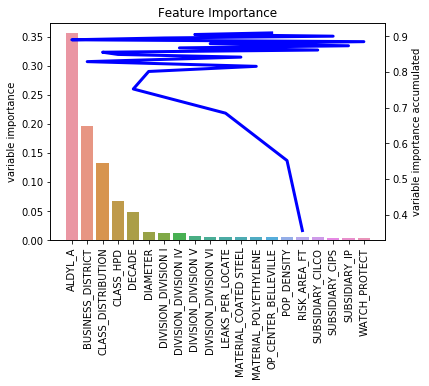

In [6]:
#####################################################################################################
################################ START: BALANCED RANDOM FOREST ######################################
#####################################################################################################
# Fit a random forest balanced classifier:
rfb = BalancedRandomForestClassifier(max_depth                  = None, 
                                     random_state               = 0,
                                     n_estimators               = 1000,
                                     criterion                  = 'gini', 
                                     min_samples_split          = 2, 
                                     min_samples_leaf           = 1, 
                                     min_weight_fraction_leaf   = 0.0, 
                                     max_features               = 'auto', 
                                     max_leaf_nodes             = None, 
                                     min_impurity_decrease      = 0.0, 
                                     bootstrap                  = True, 
                                     oob_score                  = True, 
                                     sampling_strategy          = 1, 
                                     replacement                = False, 
                                     n_jobs                     = -1,
                                     verbose                    = 0, 
                                     warm_start                 = False, 
                                     class_weight               = "balanced_subsample")

rfb.fit(train_features, train_target)

# Test set assessement: accuracy, prediction, and precision and recall information
print("Random Forest Balanced Accuracy: ", rfb.score(test_features, test_target),"\n")
rfb_pred_target = rfb.predict(test_features)
print(metrics.classification_report(rfb_pred_target, test_target))


# Create a feature importance dataframe:
train_features_pandas_df = pd.DataFrame(train_features, columns = df_features.columns)
feature_importances_rfb = pd.DataFrame(rfb.feature_importances_,
                                    index = train_features_pandas_df.columns,
                                    columns = ['importance']).sort_values('importance', ascending = False)


# Plot importance and accumulative importance:
plt.title("Feature Importance")
ax1 = sns.barplot(y = "importance", 
                  x = feature_importances_rfb.index[:20], 
                  data = feature_importances_rfb[:20])
ax1.set_ylabel("variable importance")
ax1.tick_params(axis = 'x', rotation = 90)
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(feature_importances_rfb.index[:20], 
         feature_importances_rfb[:20].cumsum(), 
         c ='blue', 
         linewidth = 3.0)
ax2.set_ylabel("variable importance accumulated")
ax2.grid(False)

plt.show()
#####################################################################################################
################################ END: BALANCED RANDOM FOREST ########################################
#####################################################################################################

In [7]:
#####################################################################################################
################################ START: BALANCED BAGGING CLASSIFIER #################################
#####################################################################################################
bbc = BalancedBaggingClassifier(base_estimator      = DecisionTreeClassifier(),
                                sampling_strategy   = 'auto',
                                replacement         = False,
                                random_state        = 0,
                                n_estimators        = 1000,
                                n_jobs              = -1)
bbc.fit(train_features, train_target) 

# Test set assessement: accuracy, prediction, and precision and recall information:
print("Balanced Bagging Accuracy: ", bbc.score(test_features, test_target),"\n")
bbc_pred_target = bbc.predict(test_features)
print(metrics.classification_report(bbc_pred_target, test_target))

### NOTE: BBC does not have a feature importance attribute but you still can creatre a confusion matrix
###       and ROC analysis. 

#####################################################################################################
################################## END: BALANCED BAGGING CLASSIFIER #################################
#####################################################################################################

Balanced Bagging Accuracy:  0.807397306971 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     18735
           1       0.62      0.11      0.19      4733

   micro avg       0.81      0.81      0.81     23468
   macro avg       0.72      0.55      0.54     23468
weighted avg       0.78      0.81      0.75     23468



In [8]:
#####################################################################################################
################################### START: EASY ENSEMBLE CLASSIFIER #################################
#####################################################################################################
eec = EasyEnsembleClassifier(base_estimator         = DecisionTreeClassifier(),
                                sampling_strategy   ='auto',
                                replacement         = False,
                                random_state        = 0,
                                n_estimators        = 1000,
                                n_jobs              = -1)
eec.fit(train_features, train_target) 

# Test set assessement: accuracy, prediction, and precision and recall information:
print("Easy Ensemble Accuracy: ", bbc.score(test_features, test_target),"\n")
bbc_pred_target = bbc.predict(test_features)
print(metrics.classification_report(bbc_pred_target, test_target))
#####################################################################################################
##################################### END: EASY ENSEMBLE CLASSIFIER #################################
#####################################################################################################

Easy Ensemble Accuracy:  0.807397306971 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     18735
           1       0.62      0.11      0.19      4733

   micro avg       0.81      0.81      0.81     23468
   macro avg       0.72      0.55      0.54     23468
weighted avg       0.78      0.81      0.75     23468



Random Under Sample Accuracy:  0.894238963695 

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     21523
           1       0.19      0.08      0.12      1945

   micro avg       0.89      0.89      0.89     23468
   macro avg       0.56      0.53      0.53     23468
weighted avg       0.86      0.89      0.88     23468



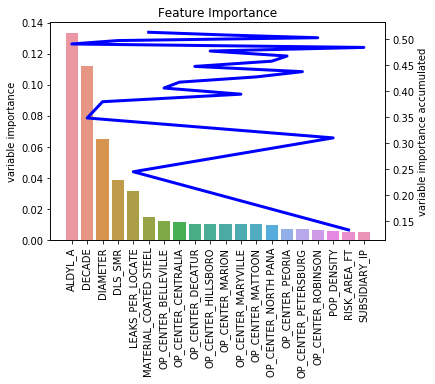

In [9]:
#####################################################################################################
######################## START: RANDOM UNDER SAMPLE BOOST CLASSIFIER ################################
#####################################################################################################
rus = RUSBoostClassifier(base_estimator      = DecisionTreeClassifier(),
                         sampling_strategy   = 1,
                         replacement         = False,
                         random_state        = 33,
                         n_estimators        = 200,
                         learning_rate       = 1)
                                
rus.fit(train_features, train_target) 


# Test set assessement: accuracy, prediction, and precision and recall information:
print("Random Under Sample Accuracy: ", rus.score(test_features, test_target),"\n")
rus_pred_target = rus.predict(test_features)
print(metrics.classification_report(rus_pred_target, test_target))

# Feature important using a pandas dataframe:
train_features_pandas_df = pd.DataFrame(train_features, columns = df_features.columns)
feature_importances_rus = pd.DataFrame(rus.feature_importances_,
                                    index = train_features_pandas_df.columns,
                                    columns = ['importance']).sort_values('importance', ascending = False)


plt.title("Feature Importance")
ax1 = sns.barplot(y = "importance", 
                  x = feature_importances_rus.index[:20], 
                  data = feature_importances_rus[:20])
ax1.set_ylabel("variable importance")
ax1.tick_params(axis = 'x', rotation = 90)
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(feature_importances_rus.index[:20], 
         feature_importances_rus[:20].cumsum(), 
         c ='blue', 
         linewidth = 3.0)
ax2.set_ylabel("variable importance accumulated")
ax2.grid(False)

plt.show()
#####################################################################################################
######################## END: RANDOM UNDER SAMPLE BOOST CLASSIFIER ##################################
#####################################################################################################